<a href="https://colab.research.google.com/github/TIO4100-IFO26/master-thesis/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Quantile Machine Learning Approach for Predicting the Equity Risk Premium**

Notebook for masteroppgave 2022
- Data hentes fra GitHub


Mål:
- Teste ut quantile machine learning for å predikere ERP, både ved å generere punktestimat og prediksjonsintervaller
- Tester ut trebaserte algoritmer på grunn av begrenset data, samt at disse algoritmene har gitt gode resultater tidligere

Motivasjon:
- Sprikende resultater i litteraturen der både enkeltvariabler og kombinasjoner av variabler har vært forsøkt, samt metoder som lineære modeller, kvantilregresjon, nevrale nettverk, osv.

Data:
- Vi vil bruke et populært datasett benyttet av mange tidligere studier for å predikere ERP. 

Modeller:
- Quantile regression forest (random forest med kvantilprediksjon)
- Quantile gradient boosting
- Historisk modell som basis

Metode:
- For hvert tidspunkt t (månedlig) vil vi beregne historisk median, mean, samt aktuelle kvantiler ved å bruke all tilgjengelig data på ERP bakover. Vi vil også trene QRF og QGB med all tilgjengelig data bakover.
- For å trene maskinlæringsmodellene som baserer seg på tidsseriedata benytter vi walk-forward cross validation 
- Vi evaluerer predikatene ved å score punktestimatene med MAE og prediksjonsintervallene med interval score

# **Data fetch**

In [1]:
!pip install --upgrade openpyxl
!pip install --upgrade xlrd

     |████████████████████████████████| 96 kB 993 kB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
!rm -r master-thesis

rm: cannot remove 'master-thesis': No such file or directory


In [3]:
#Data fra GitHub

!git clone --depth=2 -q https://github.com/TIO4100-IFO26/master-thesis.git

In [4]:
import pandas as pd
import numpy as np
dataset = pd.read_excel("/content/master-thesis/PredictorData2020.xlsx", sheet_name ="FirstSet")

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [5]:
dataset.head()
dataset.count()

yyyymm                            1800
Index                             1800
D12                               1800
E12                               1800
AAA                               1224
BAA                               1224
Rfree                             1799
Rate GS10 from Robert Schiller    1800
CRSP_SPvw                         1140
CRSP_SPvwx                        1140
IndexReturn                       1799
ERP                               1212
bm                                1198
tbl                               1212
lty                               1224
ntis                              1129
infl                              1295
ltr                               1140
corpr                             1140
svar                              1631
DP                                1800
DY                                1799
EP                                1800
DE                                1800
TMS                               1212
DFY                      

In [6]:
#gw_original.insert(len(gw_original.columns),"Log_return",np.log((gw_original.Index+gw_original.D12)/gw_original.Index.shift(1)))
#gw_original.insert(len(gw_original.columns), "tbl_logRet", gw_original.tbl.pct_change(1))
#gw_original.insert(len(gw_original.columns), "ERP", gw_original.Log_return-gw_original.tbl_logRet)
#dataset.drop(dataset[dataset['ERP']< -20].index , inplace=True)

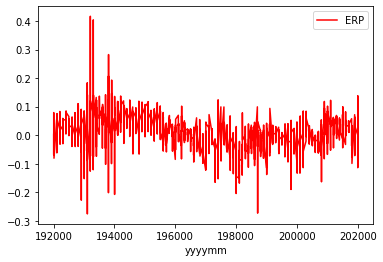

In [7]:
import matplotlib.pyplot as plt
dataset.plot(kind='line',x='yyyymm',y='ERP',color='red')
plt.show()

## **PCA for the technical indicators**

- to calculate the predictor "tchi" from Goyal and Welch 2 (2021)

In [8]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

#clean_dataset(dataset)

In [10]:
# importing or loading the dataset
# dataset = pd.read_excel('PredictorData2020.xlsx', sheet_name='Ark1', header=1)
 
# distributing the dataset into two components X and Y
X = dataset.iloc[959:, 12:43].values #feil
y = dataset.iloc[959:, 11].values #feil

#print(dataset)
#print(X)
#print(y)

In [11]:
# performing preprocessing part
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
 
X = sc.fit_transform(X)
#X_test = sc.transform(X_test)

In [12]:
# Applying PCA function on training
# and testing set of X component
from sklearn.decomposition import PCA
 
pca = PCA(n_components = 1)
 
X = pca.fit_transform(X)
#X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_

ValueError: ignored

In [ ]:
print(explained_variance)
#print(X)
pd.DataFrame(X).to_excel('output.xlsx')

In [ ]:
def tchi(row_nr, X):
  technical_indicators = pd.read_excel("/content/master-thesis/PredictorData2020.xlsx", sheet_name ="tchi")
  sc = StandardScaler()
  X = sc.fit_transform(X)
  pca = PCA(n_components = 1)
  X = pca.fit_transform(X)
  return X

# **Models**

## intro

In [13]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
dataset['ERP_(t-1)'] = dataset['ERP'].shift(1)
dataset['ERP_(t+1)'] = dataset['ERP'].shift(-1)
#type: numpy array
ERP = dataset.iloc[960:1800,45]
X = dataset.iloc[960:1800,12:45]
ALL = dataset.iloc[960:1800,11:45]

In [15]:
ERP = np.nan_to_num(ERP)
X = np.nan_to_num(X)
ALL = np.nan_to_num(ALL)

In [16]:
#Devide the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, ERP, test_size=0.20, random_state=42)
X_train = np.nan_to_num(X_train)
y_train = np.nan_to_num(y_train)
X_test = np.nan_to_num(X_test)
y_test = np.nan_to_num(y_test)

#type: pandas dataframe
X_test_df = pd.DataFrame(X_test, columns = dataset.columns[12:45])